In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import datasets
from sklearn import metrics
import seaborn as sns

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet

<h1> Hierarchical Clustering with Iris Dataset </h1>

In [3]:
# Loading datasets
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

iris_df["Species"] = iris["target"]
iris_df["Species"] = iris_df["Species"].apply(lambda x: iris["target_names"][x])

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# Remove the grain species from the DataFrame, save for later
new_iris = iris_df.drop(["Species"], axis=1)

<h2> Dendograms with the linkage methods: Single, Complete, Average and Ward </h2>

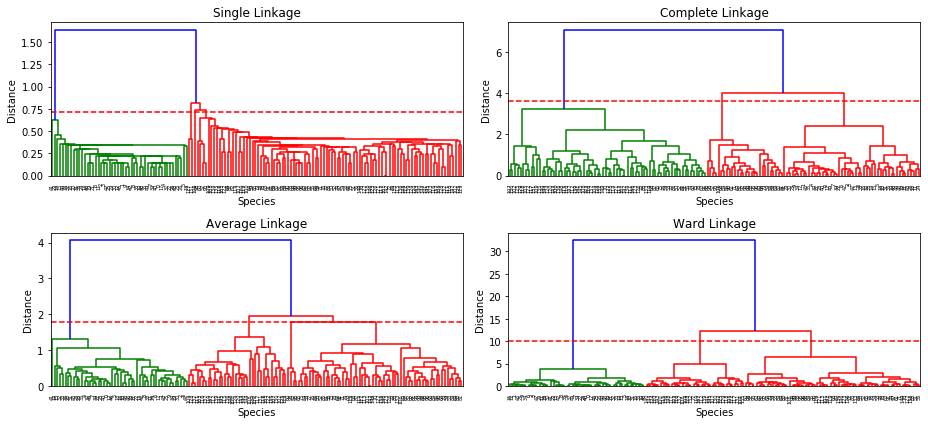

In [5]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(13,6))

plt.subplot(221)
plt.title('Single Linkage') 
shc.dendrogram((shc.linkage(new_iris, method='single'))) 
plt.axhline(y=0.72, color='r', linestyle='--')
plt.xlabel('Species')
plt.ylabel('Distance')
plt.tight_layout()

plt.subplot(222)
plt.title('Complete Linkage') 
shc.dendrogram((shc.linkage(new_iris, method='complete'))) 
plt.axhline(y=3.6, color='r', linestyle='--')
plt.xlabel('Species')
plt.ylabel('Distance')
plt.tight_layout()

plt.subplot(223)
plt.title('Average Linkage') 
shc.dendrogram((shc.linkage(new_iris, method='average'))) 
plt.axhline(y=1.8, color='r', linestyle='--')
plt.xlabel('Species')
plt.ylabel('Distance')
plt.tight_layout()

plt.subplot(224)
plt.title('Ward Linkage') 
shc.dendrogram((shc.linkage(new_iris, method='ward'))) 
plt.axhline(y=10, color='r', linestyle='--')
plt.xlabel('Species')
plt.ylabel('Distance')
plt.tight_layout()

plt.show()

<h2> Applying PCA, TSN-E, MDS and LAMP to Iris Dataset </h2>

0.0018248558044433594 1.4686179161071777 0.7128009796142578


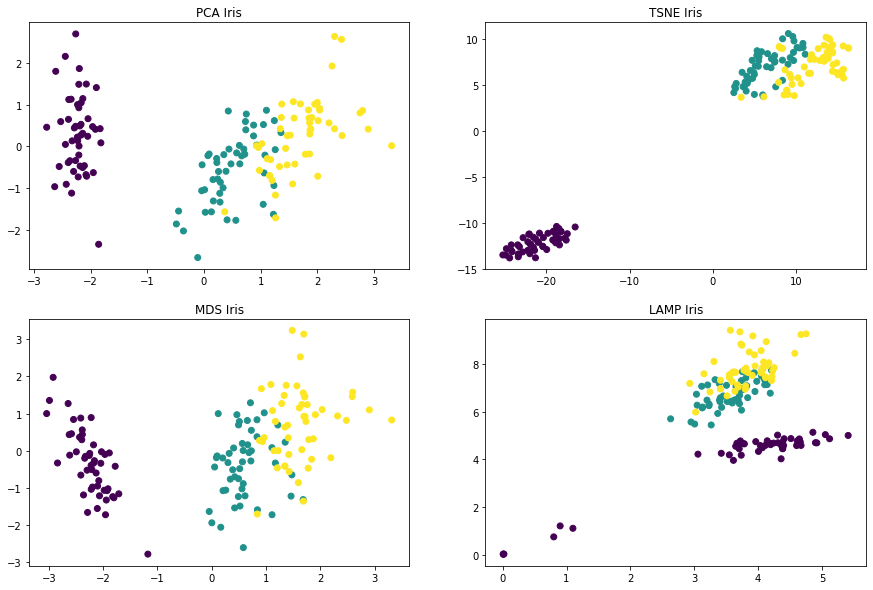

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import time
from lamp import LAMP

scaler=StandardScaler()
scaler.fit(iris.data)
X_scaled=scaler.transform(iris.data)

start_pca = time.time()
pca=PCA(n_components=2) 
pca.fit(X_scaled) 
X_pca=pca.fit_transform(X_scaled) 
pc1 = X_pca[:,0]
pc2 = X_pca[:,1]
end_pca = time.time()
time_pca = end_pca - start_pca

start_tsne = time.time()
tsne = TSNE(n_components=2) 
tsne.fit(X_scaled) 
X_tsne = tsne.fit_transform(X_scaled) 
tsne1 = X_tsne[:,0]
tsne2 = X_tsne[:,1]
end_tsne = time.time()
time_tsne = end_tsne - start_tsne

start_mds = time.time()
mds = MDS(n_components=2) 
mds.fit(X_scaled) 
X_mds = mds.fit_transform(X_scaled) 
mds1 = X_mds[:,0]
mds2 = X_mds[:,1]
end_mds = time.time()
time_mds = end_mds - start_mds

lampX = LAMP(
    iris['data'], iris['data'].copy(), 
    np.array([
        [0.01, 0.01],
        [0.02, 0.02],
        [0.01, 0.02],
        [0.9, 1.2],
        [1.1, 1.1],
        [0.8, 0.74]]
    ))

lamp1 = lampX[:,0]
lamp2 = lampX[:,1]

print (time_pca, time_tsne, time_mds)

plt.figure(figsize=(15,10))

plt.subplot (221)
plt.title('PCA Iris')
plt.scatter(pc1, pc2, c=iris['target'])

plt.subplot (222)
plt.title('TSNE Iris')
plt.scatter(tsne1, tsne2, c=iris['target'])

plt.subplot (223)
plt.title('MDS Iris')
plt.scatter(mds1, mds2, c=iris['target'])

plt.subplot (224)
plt.title('LAMP Iris')
plt.scatter(lamp1, lamp2, c=iris['target'])

plt.show()

In [22]:
from sklearn.metrics import adjusted_rand_score
import time

def calc_metrics(clf, y):
    h = metrics.homogeneity_score(y.ravel(), clf.labels_)
    c = metrics.completeness_score(y.ravel(), clf.labels_)
    v = metrics.v_measure_score(y.ravel(), clf.labels_)
    rand = adjusted_rand_score(y.ravel(), clf.labels_)
    
    measures = [{"measure": "homogeneity", 
                 "value": h},
         {"measure": "completeness", 
          "value": c},
         {"measure": "v_measure", 
          "value": v},
         {"measure": "rand", 
          "value": rand}]
    return h, c, v, rand, measures

def plot_linkage_methods(main_component, component1, component2):
    plt.figure(figsize=(12,10))
    i = 1
    linkages = []
    measures_names = []
    values = []
    for linkage_method in ['single', 'complete', 'average', 'ward']:
        start_time = time.time()
        
        cluster = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
        cluster.fit_predict(main_component)
        
        end_time = time.time()
        
        print ("Time for", linkage_method, end_time - start_time)

        h, c, v, r, measures = calc_metrics(cluster, iris["target"])

        for measure in measures:
            linkages.append(linkage_method)
            measures_names.append(measure["measure"])
            values.append(measure["value"])
            
        plt.subplot (2, 2, i)
        plt.title("Linkage: %(linkage)s\nHomogeneity: %(h).2f | Completeness: %(c).2f | V_measure: %(v).2f | Rand Score: %(r).2f" % {
            'linkage': linkage_method, 'h': h, 'c': c, 'v': v, 'r': r
        }, size=10)

        plt.scatter(component1, component2, c=cluster.labels_, cmap='rainbow')
        plt.tight_layout()
    
        i = i+1

    plt.show()
    
    
    df = pd.DataFrame({"Linkage": linkages,
                      "Measure": measures_names,
                      "Value": values}, 
                      columns=["Linkage", "Measure", "Value"])
    
    return df

def plot_measures_comparison(df):
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.barplot(x='Measure', y='Value', hue='Linkage', data=df)

<h3> Linkage methods with PCA </h3>

Time for single 0.0015659332275390625
Time for complete 0.0009899139404296875
Time for average 0.0013172626495361328
Time for ward 0.0015268325805664062


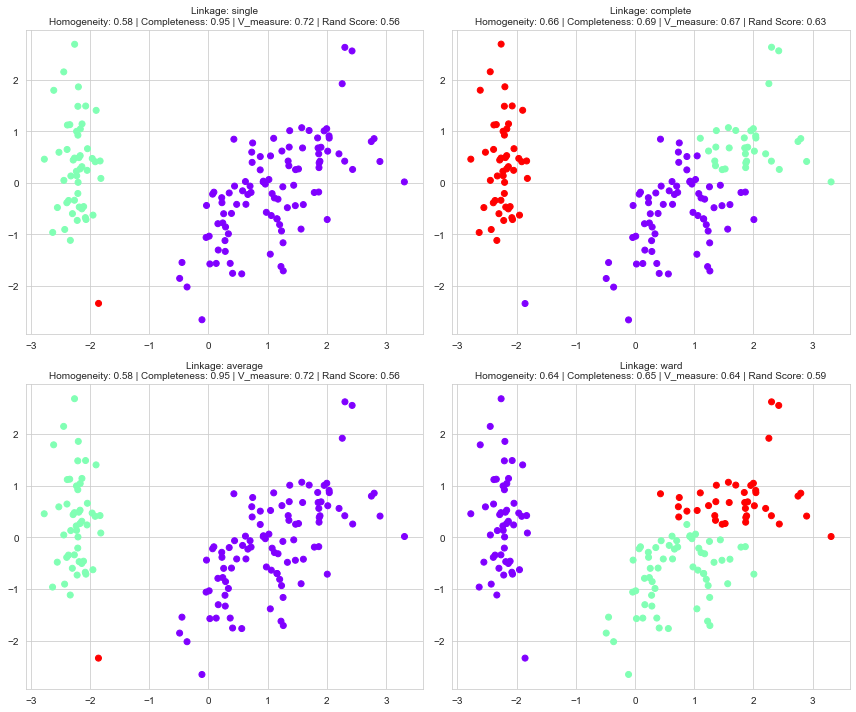

In [23]:
df_pca = plot_linkage_methods(X_pca, pc1, pc2)

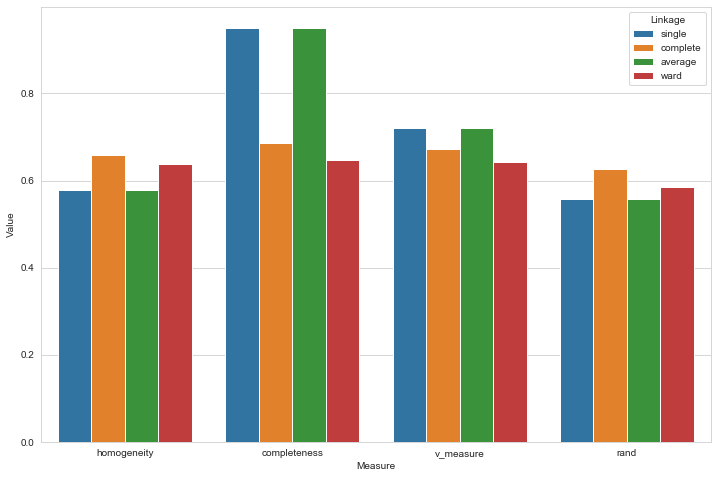

In [24]:
plot_measures_comparison(df_pca)

**PCA**

- **Homgeneity**: Complete (0.66) 
- **Completeness**: Single and Average (0.95)
- **V Measure**: Single and Average (0.72)
- **Rand Score**: Single and Average (0.56) 

<h3> Linkage methods with TSN-E </h3>

Time for single 0.0018951892852783203
Time for complete 0.0010519027709960938
Time for average 0.0010769367218017578
Time for ward 0.0016391277313232422


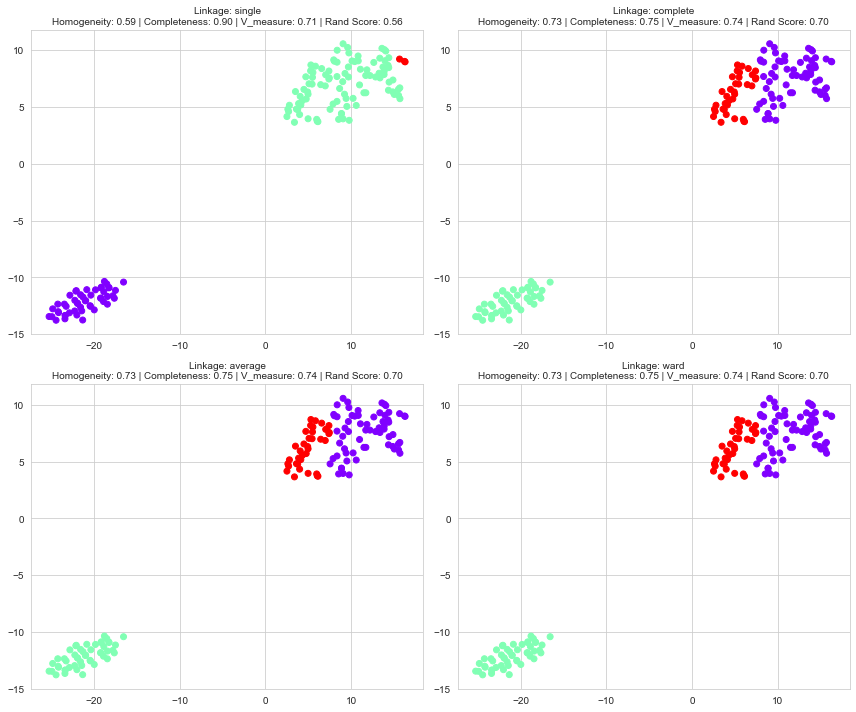

In [31]:
df_tsne = plot_linkage_methods(X_tsne, tsne1, tsne2)

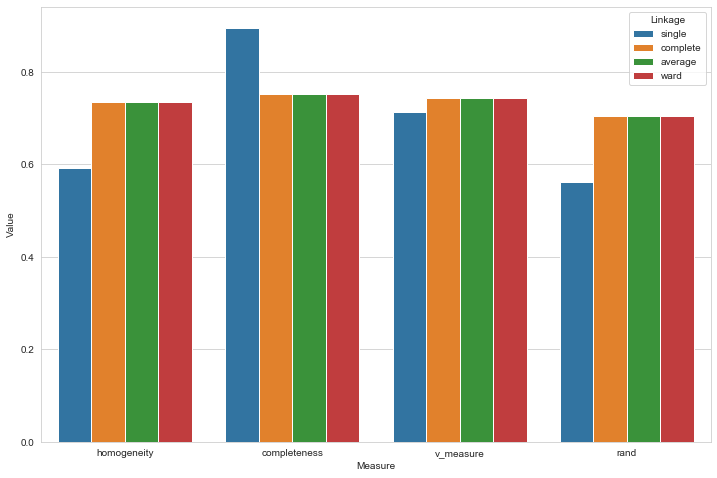

In [33]:
plot_measures_comparison(df_tsne)

**TSNE**

- **Homgeneity**: Complete, Ward and Average (0.73) 
- **Completeness**: Single (0.90)
- **V Measure**: Complete, Ward and Average (0.74)
- **Rand Score**: Complete, Ward and Average (0.70) 

<h3> Linkage methods with MDS </h3>

Time for single 0.0011858940124511719
Time for complete 0.0013530254364013672
Time for average 0.0009720325469970703
Time for ward 0.0010838508605957031


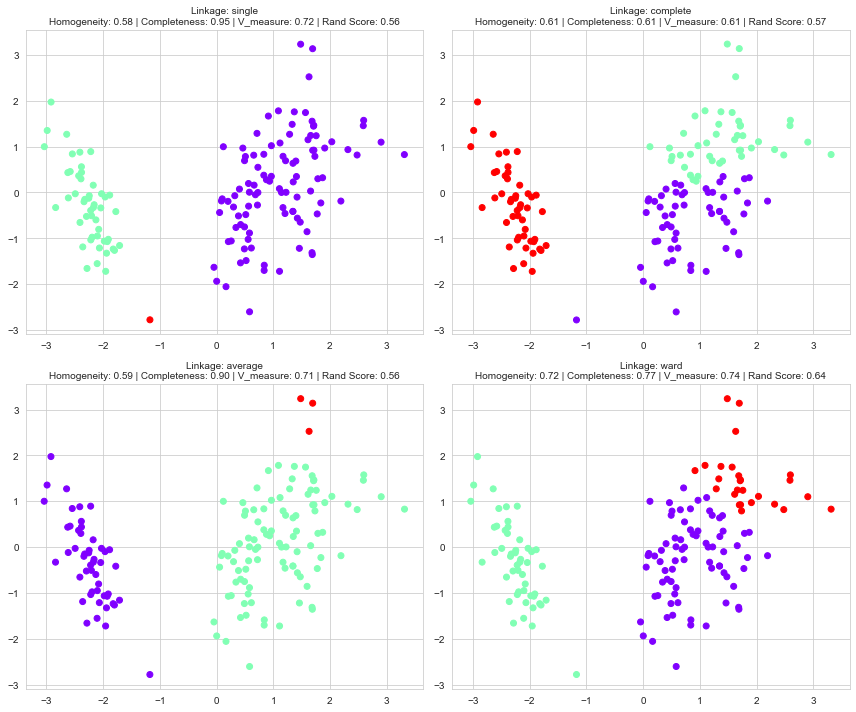

In [34]:
df_mds = plot_linkage_methods(X_mds, mds1, mds2)

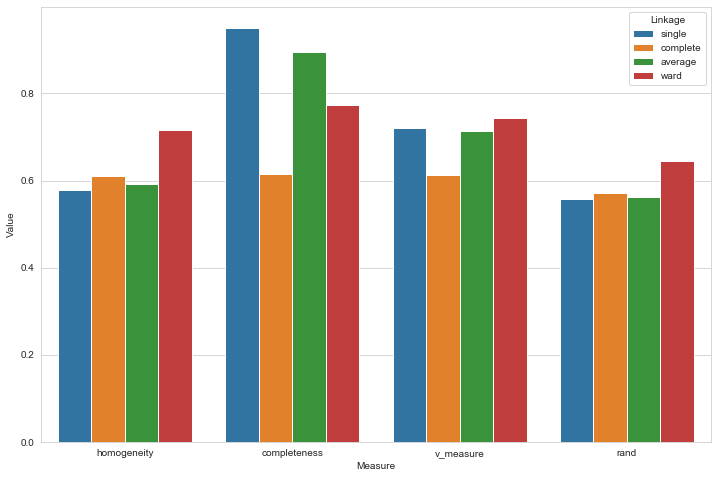

In [35]:
plot_measures_comparison(df_mds)

**MDS**

- **Homgeneity**: Ward (0.72)
- **Completeness**: Single (0.95)
- **V Measure**: Ward (0.74)
- **Rand Score**: Ward (0.64)

<h3> Linkage methods with LAMP </h3>

Time for single 0.001165151596069336
Time for complete 0.0010068416595458984
Time for average 0.0010039806365966797
Time for ward 0.0012290477752685547


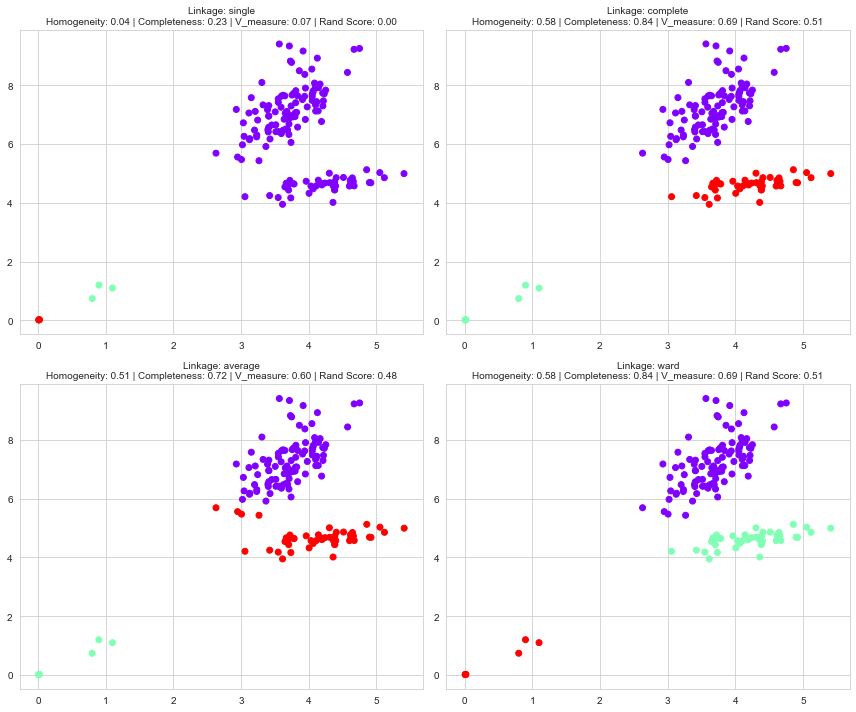

In [36]:
df_lamp = plot_linkage_methods(lampX, lamp1, lamp2)

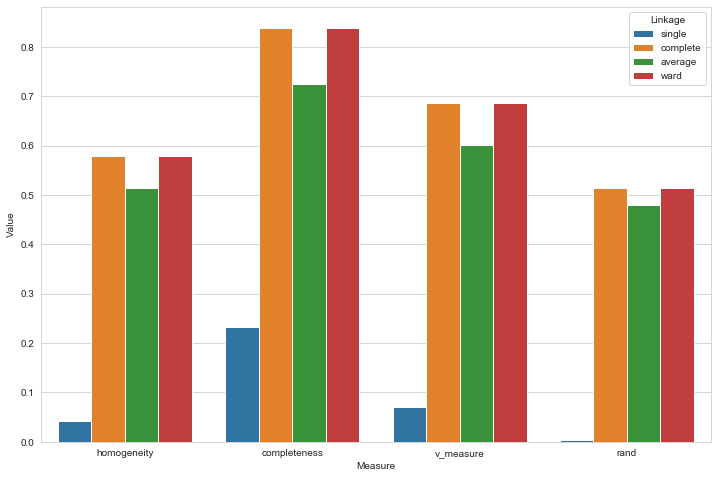

In [37]:
plot_measures_comparison(df_lamp)

In [ ]:
**LAMP**

- **Homgeneity**: Ward e Complete (0.58)
- **Completeness**: Single (0.95)
- **V Measure**: Ward (0.74)
- **Rand Score**: Ward (0.64)